# Imports

In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from collections import deque

from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

from huggingface_sb3 import push_to_hub, package_to_hub
from huggingface_hub import notebook_login, HfApi

import torch
import torch.nn as nn
import torch.optim as optim

/Users/stahlma/anaconda3/envs/gymnasium_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set Seed

In [4]:
seed = 73
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Set device to GPU if available

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Set General Environment Params

In [6]:
num_envs = 8
env_id = "ALE/Pong-v5"

In [7]:
print(gym.envs.registry.get(env_id))

EnvSpec(id='ALE/Pong-v5', entry_point='shimmy.atari_env:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'pong', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Pong', version=5, additional_wrappers=(), vector_entry_point=None)


# Stable Baselines Implementation

## PPO and A2C Implementation

### Create Vectorized Environments for PPO and A2C

In [8]:
def make_env(env_id, seed):
  def _init():
    env = gym.make(env_id)
    env = AtariWrapper(env, clip_reward=True)
    env = Monitor(env)
    env.seed(seed)
    env.action_space.seed(seed)
    return env
  return _init

envs = DummyVecEnv([make_env(env_id, seed + i) for i in range(num_envs)])

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/stahlma/anaconda3/envs/gymnasium_env/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


### Create Evaluation Environment for PPO and A2C

In [9]:
eval_env = gym.make(env_id)
eval_env = AtariWrapper(eval_env, clip_reward=False)
eval_env = Monitor(eval_env)
eval_env.reset(seed=seed)
eval_env.action_space.seed(seed)

[73]

### Training Function with Reward Callback

In [10]:
class RewardCallback(BaseCallback):
  def __init__(self):
    super(RewardCallback, self).__init__()
    self.rewards = []

  def _on_step(self):
    if 'infos' in self.locals:
      infos = self.locals['infos']
      for info in infos:
        if 'episode' in info:
          self.rewards.append(info['episode']['r'])
    return True

In [52]:
def train_and_evaluate(model_class, envs, eval_env, total_timesteps=1000, seed=73):
  callback = RewardCallback()
  start_time = time.time()
  model = model_class("CnnPolicy", envs, verbose=1, seed=seed, device=device)
  model.learn(total_timesteps=total_timesteps, callback=callback)
  training_time = time.time() - start_time
  mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
  return model, mean_reward, std_reward, training_time, callback.rewards

### Train PPO

In [53]:
ppo_model, ppo_mean_reward, ppo_std_reward, ppo_training_time, ppo_rewards = train_and_evaluate(PPO, envs, eval_env)

Using cpu device
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 206      |
|    ep_rew_mean     | -19.8    |
| time/              |          |
|    fps             | 809      |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 16384    |
---------------------------------


### Train A2C

In [57]:
a2c_model, a2c_mean_reward, a2c_std_reward, a2c_training_time, a2c_rewards = train_and_evaluate(A2C, envs, eval_env)

Using cpu device
Wrapping the env in a VecTransposeImage.


## DQN Implementation

### Create DQN Environment

In [18]:
def make_dqn_env(env_id, seed):
  env = gym.make(env_id)
  env = AtariWrapper(env, clip_reward=True)
  env = Monitor(env)
  env.reset(seed=seed)
  env.action_space.seed(seed)
  return env

dqn_env = make_dqn_env(env_id, seed)

### Create DQN Evaluation Environment

In [19]:
eval_env_dqn = gym.make(env_id)
eval_env_dqn = AtariWrapper(eval_env_dqn, clip_reward=False)
eval_env_dqn = Monitor(eval_env_dqn)
eval_env_dqn.reset(seed=seed)
eval_env_dqn.action_space.seed(seed)

[73]

### Training Function

In [58]:
def train_and_evaluate_dqn(env, eval_env, total_timesteps=1000, seed=73):
  callback = RewardCallback()
  start_time = time.time()
  model = DQN(
      "CnnPolicy",
      env,
      verbose=1,
      seed=seed,
      device = device,
      buffer_size = 100000,
      learning_starts = 50000,
      target_update_interval = 10000,
      train_freq = 4,
      exploration_fraction = 0.1,
      exploration_final_eps = 0.01
      )
  model.learn(total_timesteps=total_timesteps, callback=callback)
  training_time = time.time() - start_time
  mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
  return model, mean_reward, std_reward, training_time, callback.rewards

### Train DQN

In [59]:
dqn_model, dqn_mean_reward, dqn_std_reward, dqn_training_time, dqn_rewards = train_and_evaluate_dqn(dqn_env, eval_env_dqn)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 185      |
|    ep_rew_mean      | -17.8    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 930      |
|    time_elapsed     | 0        |
|    total_timesteps  | 741      |
----------------------------------


## Compare Models

In [60]:
data = {
    'Model': ['PPO', 'A2C', 'DQN'],
    'Mean Reward': [ppo_mean_reward, a2c_mean_reward, dqn_mean_reward],
    'Std Reward': [ppo_std_reward, a2c_std_reward, dqn_std_reward],
    'Training Time (s)': [ppo_training_time, a2c_training_time, dqn_training_time],
    'Total Steps': [ppo_model.num_timesteps, a2c_model.num_timesteps, dqn_model.num_timesteps]
}

df = pd.DataFrame(data)
df

,Model,Mean Reward,Std Reward,Training Time (s),Total Steps
0,PPO,-21.0,0.0,126.332572,16384
1,A2C,-21.0,0.0,2.130217,1000
2,DQN,-21.0,0.0,1.082509,1000


### Visualize Training Rewards

In [61]:
def plot_rewards(rewards, algorithm_name):
  plt.figure(figsize=(12, 6))
  plt.plot(rewards)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')
  plt.title(f'{algorithm_name} Training Rewards')
  plt.show()

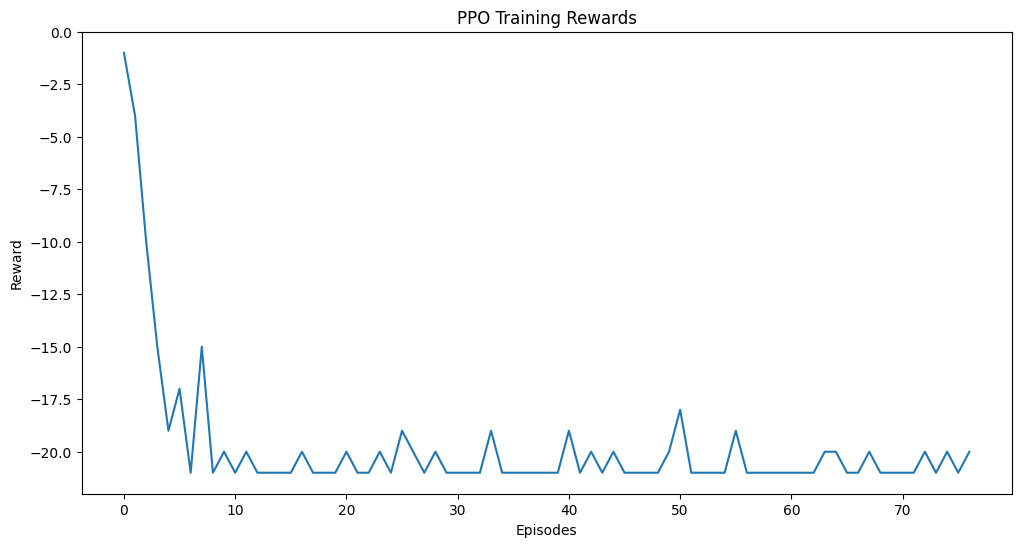

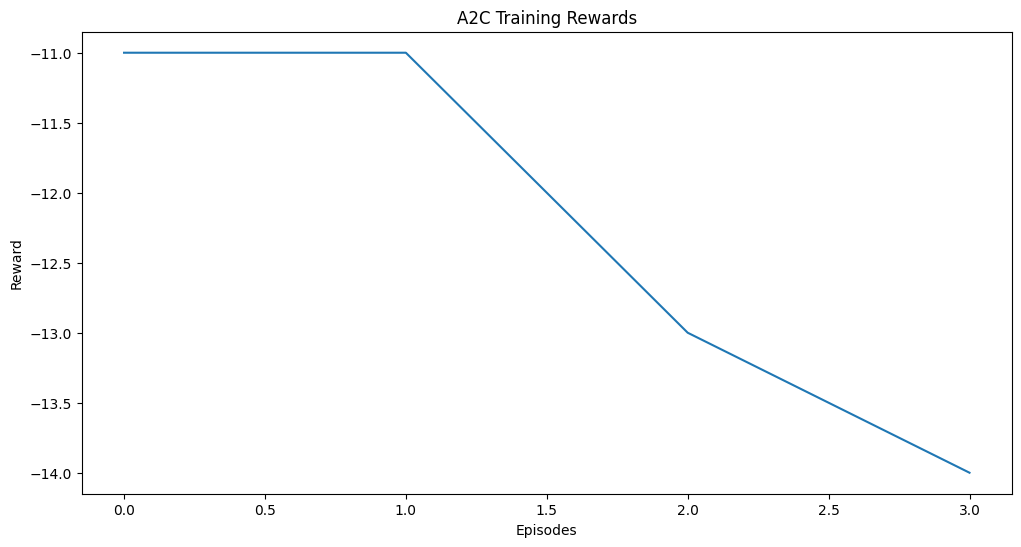

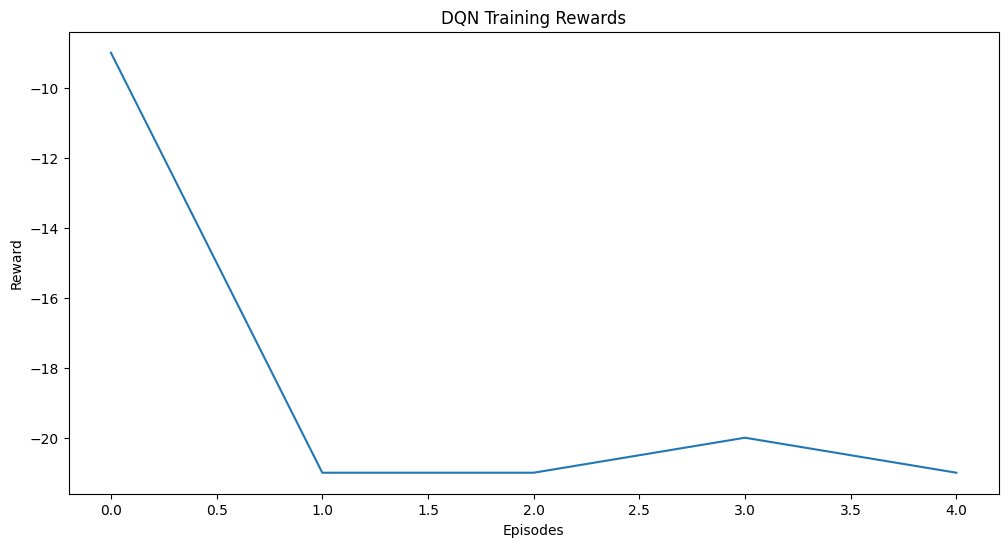

In [62]:
plot_rewards(ppo_rewards, 'PPO')
plot_rewards(a2c_rewards, 'A2C')
plot_rewards(dqn_rewards, 'DQN')

## Push Models to Huggingface

In [ ]:
notebook_login()

In [ ]:
def push_model_to_hf(model, model_name, model_architecture, env_id, repo_id, used_eval_env, commit_message):
  repo_id = repo_id
  model.save(repo_id)
  package_to_hub(model=model,
               model_name=model_name,
               model_architecture=model_architecture,
               env_id=env_id,
               eval_env=used_eval_env,
               repo_id=repo_id,
               commit_message=commit_message)

In [ ]:
push_model_to_hf(ppo_model, "ppo", "PPO", env_id, "maxstahl/ppo-Pongv5", eval_env, "PPO Training")
push_model_to_hf(a2c_model, "a2c", "A2C", env_id, "maxstahl/a2c-pongv5", eval_env, "A2C Training")
push_model_to_hf(dqn_model, "dqn", "DQN", env_id, "maxstahl/dqn-pongv5", eval_env_dqn, "DQN Training")

# Environment for Simple Implementations

In [25]:
env_simple = gym.make(env_id, frameskip=1)
env_simple = gym.wrappers.AtariPreprocessing(env_simple, scale_obs=True)
env_simple = gym.wrappers.FrameStack(env_simple, num_stack=4)

# PPO Implementation

## Define PPO Network

In [26]:
class PPONetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(PPONetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Calculate the size of the linear input
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_w = input_shape[1]
        conv_h = input_shape[2]
        for conv_layer in self.conv:
            if isinstance(conv_layer, nn.Conv2d):
                conv_w = conv2d_size_out(conv_w, conv_layer.kernel_size[0], conv_layer.stride[0])
                conv_h = conv2d_size_out(conv_h, conv_layer.kernel_size[1], conv_layer.stride[1])

        linear_input_size = conv_w * conv_h * 64

        self.fc = nn.Linear(linear_input_size, 512)
        self.policy_head = nn.Linear(512, n_actions)
        self.value_head = nn.Linear(512, 1)

    def forward(self, x):
        x = x / 255.0  # Normalize pixel values
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        policy_logits = self.policy_head(x)
        value = self.value_head(x)
        return policy_logits, value

## PPO Buffer

In [27]:
class PPOBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []

    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []

## Hyperparameters

In [28]:
gamma = 0.99
lambda_gae = 0.95
clip_epsilon = 0.1
ppo_epochs = 4
mini_batch_size = 64
entropy_coef = 0.01
value_loss_coef = 0.5
max_grad_norm = 0.5
learning_rate = 2.5e-4

## Calculate Advantage and Returns

In [29]:
def compute_gae(rewards, values, dones, next_value, gamma=0.99, lambda_=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * lambda_ * (1 - dones[step]) * gae
        returns.insert(0, gae + values[step])
    advantages = [ret - val for ret, val in zip(returns, values[:-1])]
    return returns, advantages

## Training Loop

In [88]:
def train_ppo(env, num_steps, device):
    n_actions = env.action_space.n
    state_shape = env.observation_space.shape  # (84, 84, 4)

    model = PPONetwork(state_shape, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize variables
    buffer = PPOBuffer()
    episode_rewards = []
    total_steps = 0
    start_time = time.time()
    num_env_steps = num_steps
    rollout_length = 2048  # Number of steps to collect before updating
    state, _ = env.reset()
    state = np.array(state)
    state = torch.tensor(state, device=device).unsqueeze(0).float()
    episode_reward = 0
    episode = 0
    losses = []

    while total_steps < num_env_steps:
        for _ in range(rollout_length):
            with torch.no_grad():
                logits, value = model(state)
                probs = nn.functional.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            episode_reward += reward

            # Store data in buffer
            buffer.states.append(state)
            buffer.actions.append(action)
            buffer.log_probs.append(log_prob)
            buffer.values.append(value)
            buffer.rewards.append(torch.tensor([reward], device=device))
            buffer.dones.append(torch.tensor([done], device=device, dtype=torch.float))

            state = np.array(next_state)

            state = torch.tensor(state, device=device).unsqueeze(0).float()
            total_steps += 1

            if done:
                episode += 1
                episode_rewards.append(episode_reward)
                episode_reward = 0
                state, _ = env.reset()
                state = np.array(state)
                state = torch.tensor(state, device=device).unsqueeze(0).float()

        # Compute returns and advantages
        with torch.no_grad():
            _, next_value = model(state)
        returns, advantages = compute_gae(
            [r.item() for r in buffer.rewards],
            [v.item() for v in buffer.values],
            [d.item() for d in buffer.dones],
            next_value.item(),
            gamma,
            lambda_gae
        )
        returns = torch.tensor(returns, device=device).unsqueeze(1)
        advantages = torch.tensor(advantages, device=device).unsqueeze(1)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Flatten buffers
        states = torch.cat(buffer.states)
        actions = torch.cat(buffer.actions).unsqueeze(1)
        old_log_probs = torch.cat(buffer.log_probs).detach()
        values = torch.cat(buffer.values).detach()

        # PPO Update
        for _ in range(ppo_epochs):
            idx = np.random.permutation(len(states))
            for i in range(0, len(states), mini_batch_size):
                ind = idx[i:i + mini_batch_size]
                batch_states = states[ind]
                batch_actions = actions[ind]
                batch_old_log_probs = old_log_probs[ind]
                batch_returns = returns[ind]
                batch_advantages = advantages[ind]

                logits, value = model(batch_states)
                probs = nn.functional.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(batch_actions.squeeze())

                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages.squeeze()
                surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * batch_advantages.squeeze()
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = nn.functional.mse_loss(value.squeeze(), batch_returns.squeeze())
                loss = policy_loss + value_loss_coef * value_loss - entropy_coef * entropy
                losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

        buffer.clear()

        if episode % 10 == 0 and episode > 0:
            mean_reward = np.mean(episode_rewards[-10:])
            print(f"Total Steps: {total_steps}, Episode: {episode}, Mean Reward: {mean_reward:.2f}")

    total_training_time = time.time() - start_time
    env.close()
    print("Training complete!")
    print(f"Total training time: {total_training_time:.2f} seconds")
    return model, episode_rewards, total_training_time, losses

## Train the Model

In [89]:
num_steps = 10000
ppo_simple_model, ppo_simple_episode_rewards, ppo_simple_training_time, ppo_simple_losses = train_ppo(env_simple, num_steps=num_steps, device=device)

Total Steps: 10240, Episode: 10, Mean Reward: -20.20
Training complete!
Total training time: 49.52 seconds


## Save and Upload the model to Huggingface

In [ ]:
torch.save(ppo_model.state_dict(), 'simple_ppo_pong.pth')

In [ ]:
api = HfApi()
api.upload_file(
    path_or_fileobj='simple_ppo_pong.pth',
    path_in_repo='simple_ppo_pong.pth',
    repo_id='your_username/simple-ppo-pong',  # Replace with your username
    repo_type='model',
    commit_message='Upload simple PPO model'
)

# A2C Implementation


*   Actor-Critic Architecture
*   Advantage estimation
*   On-policy updates




## Define the A2C Network

In [33]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ActorCritic, self).__init__()
        print(f"Input shape: {input_shape}")
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Calculate the size of the linear input
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
        conv_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
        linear_input_size = conv_w * conv_h * 64

        self.fc = nn.Linear(linear_input_size, 512)
        self.actor = nn.Linear(512, n_actions)
        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = x / 255.0
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value

## Training Loop

In [90]:
def train_a2c(env, num_steps, device):
    n_actions = env.action_space.n
    state_shape = env.observation_space.shape  # Should be (4, 84, 84)
    print(f"Input shape: {state_shape}")

    # Initialize the model and optimizer
    model = ActorCritic(state_shape, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Hyperparameters
    gamma = 0.99
    entropy_coef = 0.01
    value_loss_coef = 0.5
    max_grad_norm = 0.5
    num_steps_per_update = 5  # Number of steps to collect before each update
    total_steps = 0
    episode_rewards = []
    losses = []
    start_time = time.time()

    # Reset the environment and process initial state
    state, _ = env.reset()
    state = np.array(state)
    state = torch.tensor(state, device=device).unsqueeze(0).float()
    episode_reward = 0  # Initialize episode reward

    while total_steps < num_steps:
        log_probs = []
        values = []
        rewards = []
        entropies = []
        dones = []
        steps_collected = 0

        # Collect experience for num_steps_per_update steps
        while steps_collected < num_steps_per_update and total_steps < num_steps:
            # Forward pass
            logits, value = model(state)
            probs = nn.functional.softmax(logits, dim=-1)
            log_prob = nn.functional.log_softmax(logits, dim=-1)
            entropy = -(log_prob * probs).sum(1, keepdim=True)
            action = probs.multinomial(num_samples=1)

            # Take action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            episode_reward += reward

            # Convert next_state to tensor
            next_state = np.array(next_state)
            next_state = torch.tensor(next_state, device=device).unsqueeze(0).float()

            # Store transition data
            rewards.append(torch.tensor([reward], device=device))
            log_probs.append(log_prob.gather(1, action))
            values.append(value)
            entropies.append(entropy)
            dones.append(torch.tensor([done], device=device, dtype=torch.float))

            # Move to the next state
            state = next_state
            total_steps += 1
            steps_collected += 1

            if done:
                episode_rewards.append(episode_reward)
                episode_reward = 0
                state, _ = env.reset()
                state = np.array(state)
                state = torch.tensor(state, device=device).unsqueeze(0).float()

        # Compute returns and advantages
        with torch.no_grad():
            if done:
                next_value = torch.zeros(1, 1, device=device)
            else:
                _, next_value = model(state)

        returns = []
        R = next_value
        for r, d in zip(reversed(rewards), reversed(dones)):
            R = r + gamma * R * (1 - d)
            returns.insert(0, R)

        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs)
        values = torch.cat(values).squeeze()
        entropies = torch.cat(entropies).squeeze()
        advantage = returns - values

        # Loss calculation
        value_loss = advantage.pow(2).mean()
        policy_loss = -(log_probs * advantage.detach()).mean()
        entropy_loss = entropies.mean()

        loss = policy_loss + value_loss_coef * value_loss - entropy_coef * entropy_loss
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        if len(episode_rewards) % 10 == 0 and len(episode_rewards) > 0:
            mean_reward = np.mean(episode_rewards[-10:])
            print(f"Total Steps: {total_steps}, Episodes: {len(episode_rewards)}, Mean Reward: {mean_reward:.2f}")

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")
    env.close()
    print("Training complete!")

    return model, episode_rewards, training_time, losses

## Train the Model

In [91]:
num_steps = 10000
a2c_simple_model, a2c_simple_episode_rewards, a2c_simple_training_time, a2c_simple_losses = train_a2c(env_simple, num_steps, device)

Input shape: (4, 84, 84)
Input shape: (4, 84, 84)
Total Steps: 8860, Episodes: 10, Mean Reward: -20.40
Total Steps: 8865, Episodes: 10, Mean Reward: -20.40
Total Steps: 8870, Episodes: 10, Mean Reward: -20.40
Total Steps: 8875, Episodes: 10, Mean Reward: -20.40
Total Steps: 8880, Episodes: 10, Mean Reward: -20.40
Total Steps: 8885, Episodes: 10, Mean Reward: -20.40
Total Steps: 8890, Episodes: 10, Mean Reward: -20.40
Total Steps: 8895, Episodes: 10, Mean Reward: -20.40
Total Steps: 8900, Episodes: 10, Mean Reward: -20.40
Total Steps: 8905, Episodes: 10, Mean Reward: -20.40
Total Steps: 8910, Episodes: 10, Mean Reward: -20.40
Total Steps: 8915, Episodes: 10, Mean Reward: -20.40
Total Steps: 8920, Episodes: 10, Mean Reward: -20.40
Total Steps: 8925, Episodes: 10, Mean Reward: -20.40
Total Steps: 8930, Episodes: 10, Mean Reward: -20.40
Total Steps: 8935, Episodes: 10, Mean Reward: -20.40
Total Steps: 8940, Episodes: 10, Mean Reward: -20.40
Total Steps: 8945, Episodes: 10, Mean Reward: -20

## Save and Upload the Model to Huggingface

In [36]:
# Save the model
torch.save(a2c_model.state_dict(), 'simple_a2c_pong.pth')

AttributeError: 'A2C' object has no attribute 'state_dict'

In [ ]:
# Upload to Hugging Face
api.upload_file(
    path_or_fileobj='simple_a2c_pong.pth',
    path_in_repo='simple_a2c_pong.pth',
    repo_id='your_username/simple-a2c-pong',  # Replace with your username
    repo_type='model',
    commit_message='Upload simple A2C model'
)

# DQN Implementation



*   Q-Learning with a neural network to approximate the Q function
*   Experience replay buffer
*   Use of target network to stabilize training






## Define the Q-Network

In [120]:
class DQNNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQNNetwork, self).__init__()
        # Assuming input_shape = (4, 84, 84)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Compute the size of the linear input
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_w = input_shape[2]
        conv_h = input_shape[1]
        conv_w = conv2d_size_out(conv_w, 8, 4)
        conv_h = conv2d_size_out(conv_h, 8, 4)
        conv_w = conv2d_size_out(conv_w, 4, 2)
        conv_h = conv2d_size_out(conv_h, 4, 2)
        conv_w = conv2d_size_out(conv_w, 3, 1)
        conv_h = conv2d_size_out(conv_h, 3, 1)

        linear_input_size = conv_w * conv_h * 64
        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = x / 255.0  # Normalize pixel values
       # x = x.permute(0, 3, 1, 2)  # Rearrange dimensions to [batch_size, channels, height, width]
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

## Experience Replay Buffer

In [121]:
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = []
    self.position = 0

  def push(self, state, action, reward, next_state, done):
    """ save a transition """
    if len(self.buffer) < self.capacity:
      self.buffer.append(None)
    self.buffer[self.position] = (state, action, reward, next_state, done)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    """ sample a batch of transitions """
    batch = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = map(np.stack, zip(*batch))
    return state, action, reward, next_state, done

  def __len__(self):
    return len(self.buffer)

## Epsilon-Greedy Action Selection

In [122]:
def select_action(state, epsilon, n_actions, policy_net, device):
  if random.random() > epsilon:
    with torch.no_grad():
      state = torch.tensor(state, device=device).unsqueeze(0)
      q_values = policy_net(state)
      action = q_values.argmax().item()
  else:
    action = random.randrange(n_actions)
  return action

# Training Loop

In [138]:
def train_dqn(env, num_steps, device):
    n_actions = env.action_space.n
    state_shape = env.observation_space.shape  # Should be (4, 84, 84)
    print(f"Input shape: {state_shape}")

    # Initialize the policy and target networks
    policy_net = DQNNetwork(state_shape, n_actions).to(device)
    target_net = DQNNetwork(state_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    replay_buffer = ReplayBuffer(100000)
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.1
    epsilon_decay = 500000  # Adjust as needed
    target_update_interval = 1000
    total_steps = 0
    episode_rewards = []
    losses = []
    start_time = time.time()
    episode = 0

    # Reset the environment and initialize state
    state, _ = env.reset()
    state = np.array(state)
    state = torch.tensor(state, device=device).unsqueeze(0).float()  # Shape: (1, 4, 84, 84)
    episode_reward = 0

    while total_steps < num_steps:
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * total_steps / epsilon_decay)
        # Select action
        if random.random() > epsilon:
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()
        else:
            action = random.randrange(n_actions)

        # Take action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        # Process next_state
        next_state = np.array(next_state)
        next_state_tensor = torch.tensor(next_state, device=device).unsqueeze(0).float()

        # Store transition in the replay buffer
        replay_buffer.push(state.squeeze(0).cpu().numpy(), action, reward, next_state_tensor.squeeze(0).cpu().numpy(), done)

        # Move to the next state
        state = next_state_tensor
        total_steps += 1

        # Training step
        if len(replay_buffer) > batch_size and total_steps > 10000:
            # Sample a batch from the replay buffer
            states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = replay_buffer.sample(batch_size)

            # Convert batches to tensors
            states_batch = torch.tensor(states_batch, device=device, dtype=torch.float32) # Shape: (batch_size, 4, 84, 84)
            actions_batch = torch.tensor(actions_batch, device=device, dtype=torch.int64).unsqueeze(1)
            rewards_batch = torch.tensor(rewards_batch, device=device, dtype=torch.float32).unsqueeze(1)
            next_states_batch = torch.tensor(next_states_batch, device=device, dtype=torch.float32)
            dones_batch = torch.tensor(dones_batch, device=device, dtype=torch.float32).unsqueeze(1)

            # Compute Q-values
            q_values = policy_net(states_batch).gather(1, actions_batch)
            with torch.no_grad():
                max_next_q_values = target_net(next_states_batch).max(1)[0].unsqueeze(1)
                expected_q_values = rewards_batch + (gamma * max_next_q_values * (1 - dones_batch.type(torch.float32)))

            loss = nn.functional.mse_loss(q_values, expected_q_values)
            losses.append(loss.item())

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

        # Update the target network
        if total_steps % target_update_interval == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if done:
            episode_rewards.append(episode_reward)
            episode_reward = 0
            episode += 1
            state, _ = env.reset()
            state = np.array(state)
            state = torch.tensor(state, device=device).unsqueeze(0).float()

            if episode % 10 == 0 and episode > 0:
                mean_reward = np.mean(episode_rewards[-10:])
                print(f"Total Steps: {total_steps}, Episodes: {episode}, Mean Reward: {mean_reward:.2f}")
        print(f"Total Steps: {total_steps}")

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")
    env.close()
    print("Training complete!")

    return policy_net, episode_rewards, training_time, losses

## Train the Model

In [139]:
num_episodes = 20000
dqn_simple_policy_net, dqn_simple_episode_rewards, dqn_simple_training_time, dqn_simple_losses = train_dqn(env_simple, num_episodes, device)

Input shape: (4, 84, 84)
Total Steps: 1
Total Steps: 2
Total Steps: 3
Total Steps: 4
Total Steps: 5
Total Steps: 6
Total Steps: 7
Total Steps: 8
Total Steps: 9
Total Steps: 10
Total Steps: 11
Total Steps: 12
Total Steps: 13
Total Steps: 14
Total Steps: 15
Total Steps: 16
Total Steps: 17
Total Steps: 18
Total Steps: 19
Total Steps: 20
Total Steps: 21
Total Steps: 22
Total Steps: 23
Total Steps: 24
Total Steps: 25
Total Steps: 26
Total Steps: 27
Total Steps: 28
Total Steps: 29
Total Steps: 30
Total Steps: 31
Total Steps: 32
Total Steps: 33
Total Steps: 34
Total Steps: 35
Total Steps: 36
Total Steps: 37
Total Steps: 38
Total Steps: 39
Total Steps: 40
Total Steps: 41
Total Steps: 42
Total Steps: 43
Total Steps: 44
Total Steps: 45
Total Steps: 46
Total Steps: 47
Total Steps: 48
Total Steps: 49
Total Steps: 50
Total Steps: 51
Total Steps: 52
Total Steps: 53
Total Steps: 54
Total Steps: 55
Total Steps: 56
Total Steps: 57
Total Steps: 58
Total Steps: 59
Total Steps: 60
Total Steps: 61
Total St

# Save and Upload the Model to Huggingface

In [50]:
torch.save(dqn_simple_policy_net.state_dict(), "simple_dqn_model.pth")

In [ ]:
notebook_login()

In [ ]:
# Upload to Hugging Face
api = HfApi()
api.upload_file(
    path_or_fileobj='simple_dqn_pong.pth',
    path_in_repo='simple_dqn_pong.pth',
    repo_id='your_username/simple-dqn-pong',  # Replace with your username
    repo_type='model',
    commit_message='Upload simple DQN model'
)

# Model Comparison

## Summary Table

In [140]:
data = {
    'Algorithm': ['DQN', 'A2C', 'PPO'],
    'Mean Reward': [np.mean(dqn_simple_episode_rewards[-10:]), np.mean(a2c_simple_episode_rewards[-10:]), np.mean(ppo_simple_episode_rewards[-10:])],
    'Std Reward': [np.std(dqn_simple_episode_rewards[-10:]), np.std(a2c_simple_episode_rewards[-10:]), np.std(ppo_simple_episode_rewards[-10:])],
    'Training Time (s)': [dqn_simple_training_time, a2c_simple_training_time, ppo_simple_training_time]
}

df = pd.DataFrame(data)
print(df)

  Algorithm  Mean Reward  Std Reward  Training Time (s)
0       DQN        -20.3    1.004988         539.078209
1       A2C        -20.5    0.806226          35.021046
2       PPO        -20.2    0.748331          49.523837


## Training Reward Visualization

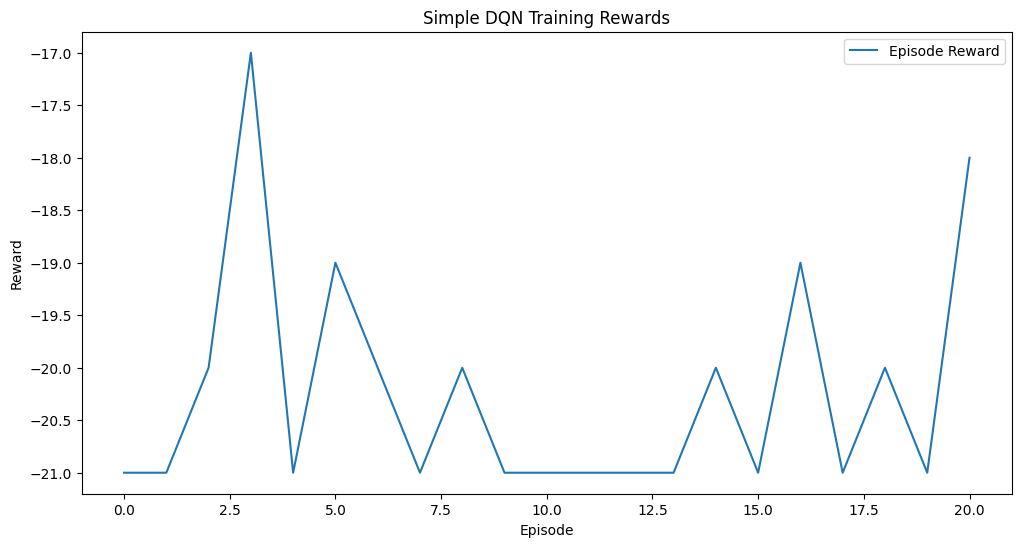

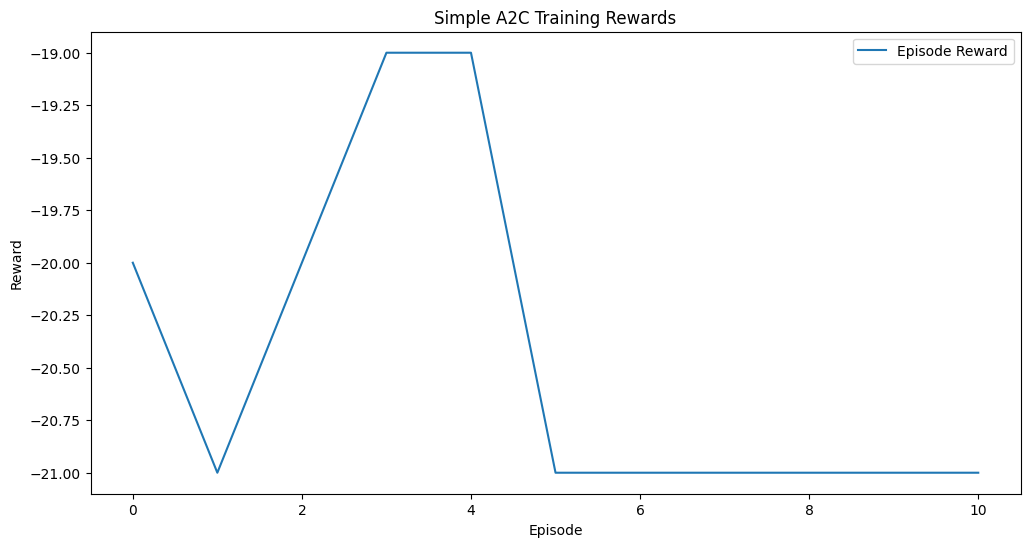

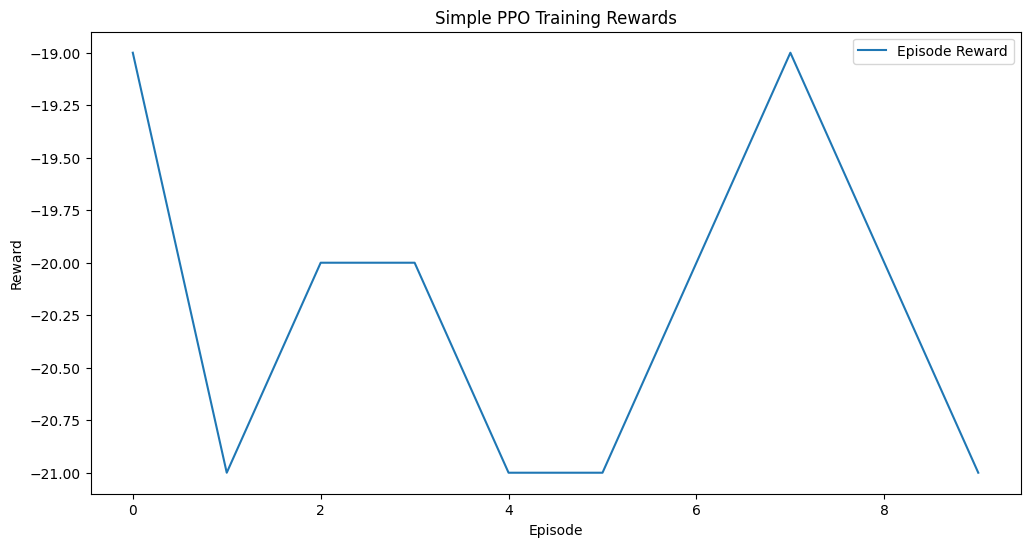

In [141]:
def plot_rewards(rewards, algorithm_name):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward')
    plt.title(f"{algorithm_name} Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

# Plotting the rewards
plot_rewards(dqn_simple_episode_rewards, "Simple DQN")
plot_rewards(a2c_simple_episode_rewards, "Simple A2C")
plot_rewards(ppo_simple_episode_rewards, "Simple PPO")

In [96]:
def plot_smoothed_rewards(rewards, algorithm_name, window=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_rewards, label=f'Smoothed Reward (window={window})', color='orange')
    plt.title(f"{algorithm_name} Smoothed Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

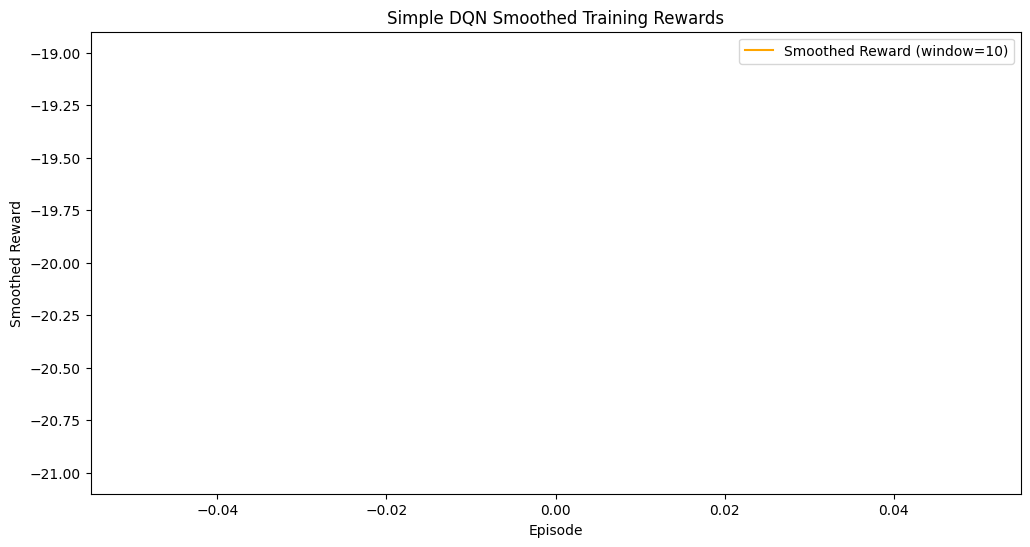

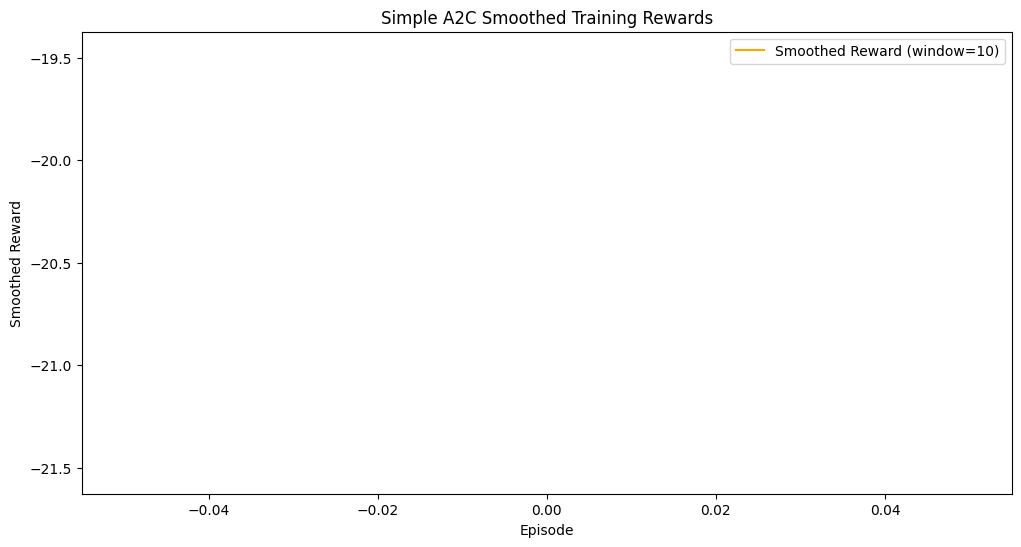

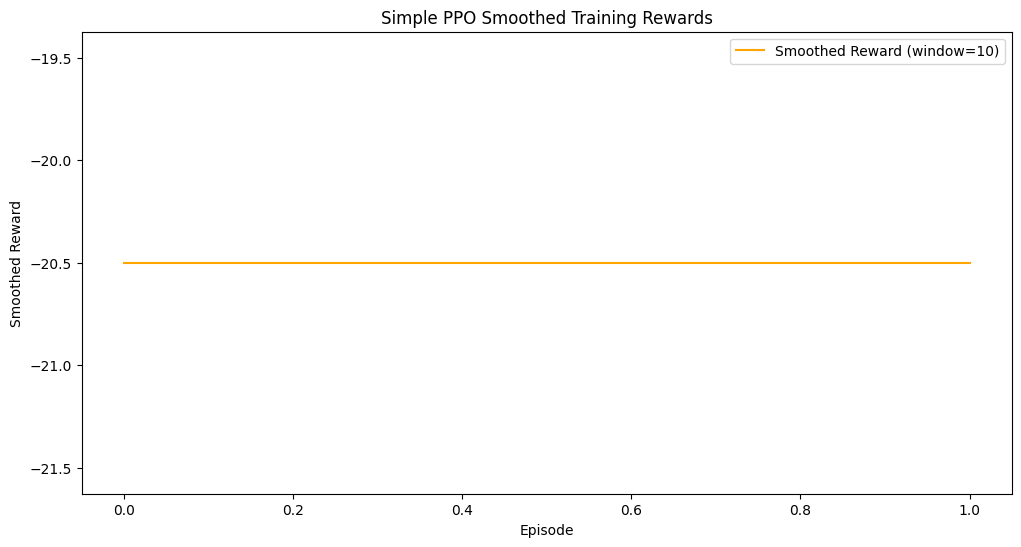

In [85]:
plot_smoothed_rewards(dqn_simple_episode_rewards, "Simple DQN")
plot_smoothed_rewards(a2c_simple_episode_rewards, "Simple A2C")
plot_smoothed_rewards(ppo_simple_episode_rewards, "Simple PPO")

In [97]:
def plot_loss(losses, algorithm_name):
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Loss')
    plt.title(f"{algorithm_name} Training Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

[0.029627032577991486, 0.02979314886033535, 0.0016181356040760875, 0.06151062250137329, 0.031109148636460304, 0.0015305038541555405, 0.001558768330141902, 0.032997678965330124, 0.0012468838831409812, 0.1211966872215271, 0.033345628529787064, 0.0006412356160581112, 0.03273284435272217, 0.000769184494856745, 0.0005278702010400593, 0.0006367446621879935, 0.02916640415787697, 0.030857032164931297, 0.0006321383407339454, 0.05957387387752533, 0.00039811054011806846, 0.031074484810233116, 0.02866395004093647, 0.0006324037094600499, 0.0004267378826625645, 0.031099941581487656, 0.0007509016431868076, 0.03141363710165024, 0.031061092391610146, 0.0005663355113938451, 0.0006540266913361847, 0.09286167472600937, 0.000581806933041662, 0.08964341133832932, 0.0005827259737998247, 0.0006961148465052247, 0.03284192830324173, 0.03266375511884689, 0.029265880584716797, 0.031083161011338234, 0.061466559767723083, 0.0006280599627643824, 0.0006656819605268538, 0.0005411679740063846, 0.00047035166062414646, 0

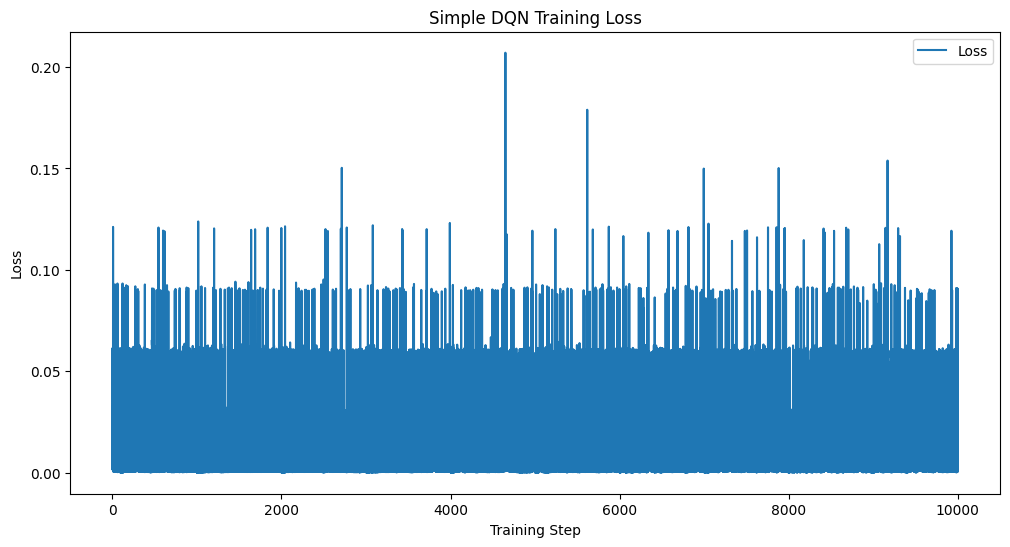

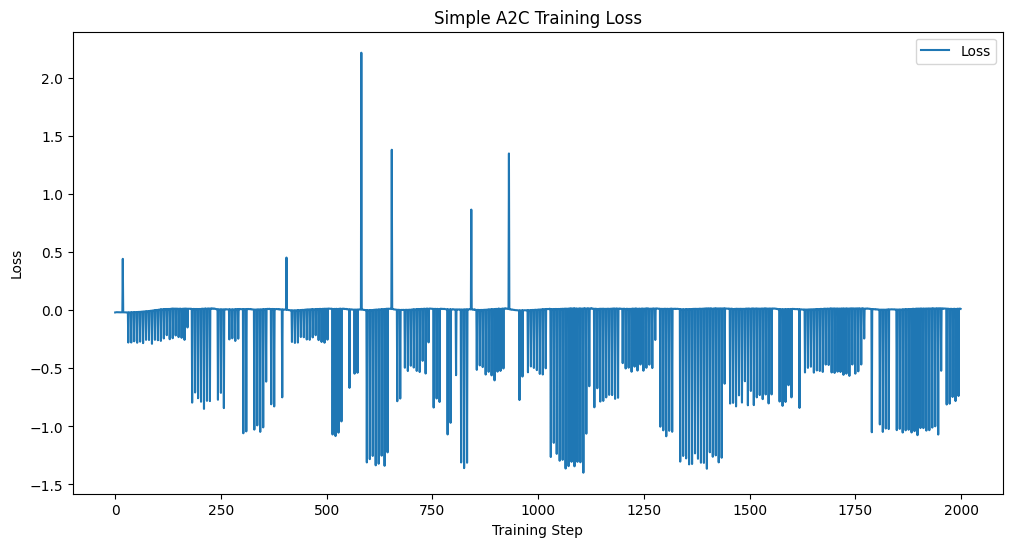

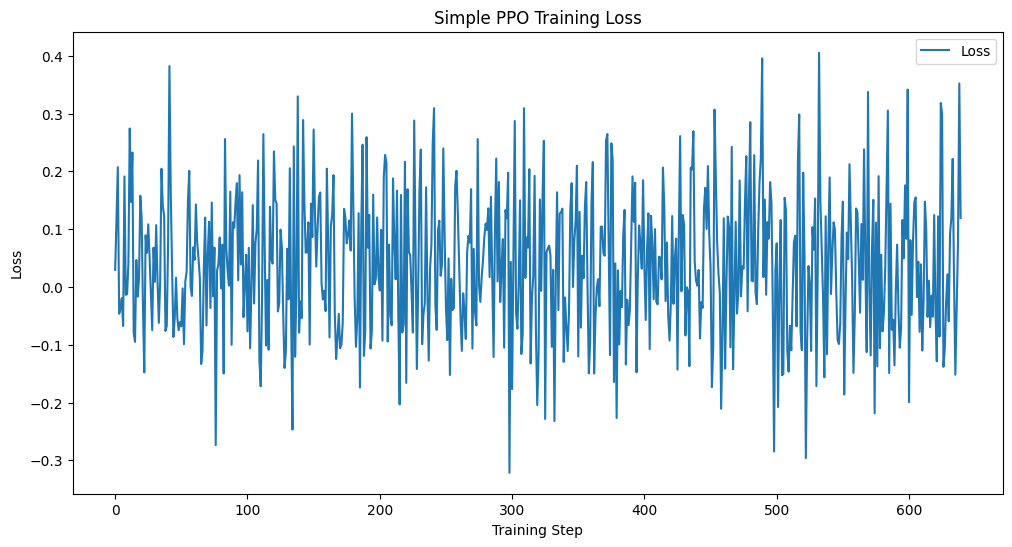

In [142]:
print(dqn_simple_losses)

plot_loss(dqn_simple_losses, "Simple DQN")
plot_loss(a2c_simple_losses, "Simple A2C")
plot_loss(ppo_simple_losses, "Simple PPO")